In [2]:
from data.sampling import simple_sample, pair_sample
from models.velocity import VelocityMLP
from training import train_flow_matching
from inference import compare_inference, ode_backward
import torch
import matplotlib.pyplot as plt

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [3]:
%load_ext autoreload
%autoreload 2

# 1. Train a Teacher flow model

## Specify a data distribution with classes

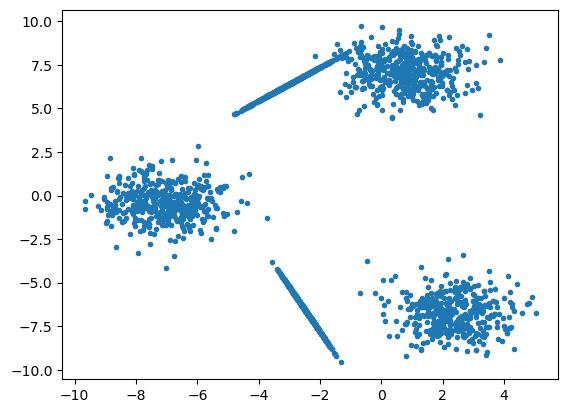

In [16]:
# Specific the data distribution
# C: number of classes, 
# N: number of dimensions of ambient space
C, N = 5, 2
sampler = simple_sample(C, N, dims=[2,2,1,1,2])


# Quick sanity check sample on the chosen device and plot the samples
x0, c = sampler(2048, device=device, class_idx = None)
x0 = x0.detach().cpu().numpy()
plt.plot(x0[:, 0], x0[:, 1], '.')
plt.show()

In [19]:
sampler_eg1 = sampler

## Train a conditional velocity to learn this distribution

In [17]:
# Model and training
model = VelocityMLP(num_classes=C, dim=N, hidden_dim=256, num_layers=4).to(device)
losses = train_flow_matching(
    model,
    sampler,
    num_steps=10000,
    batch_size=128,
    drop_label_prob=0.1,
    device=device,
)


step 100/10000 loss 4.521169
step 200/10000 loss 2.610760
step 300/10000 loss 2.897499
step 400/10000 loss 2.918415
step 500/10000 loss 2.778872
step 600/10000 loss 1.939887
step 700/10000 loss 3.164213
step 800/10000 loss 2.109342
step 900/10000 loss 2.530745
step 1000/10000 loss 3.813380
step 1100/10000 loss 2.092195
step 1200/10000 loss 2.865384
step 1300/10000 loss 1.957175
step 1400/10000 loss 2.155782
step 1500/10000 loss 2.099049
step 1600/10000 loss 3.201440
step 1700/10000 loss 2.079244
step 1800/10000 loss 3.192498
step 1900/10000 loss 2.873612
step 2000/10000 loss 2.246041
step 2100/10000 loss 2.885474
step 2200/10000 loss 2.195404
step 2300/10000 loss 2.544192
step 2400/10000 loss 2.124604
step 2500/10000 loss 2.212186
step 2600/10000 loss 1.923739
step 2700/10000 loss 2.185197
step 2800/10000 loss 3.038372
step 2900/10000 loss 2.122323
step 3000/10000 loss 2.455572
step 3100/10000 loss 2.632612
step 3200/10000 loss 2.700291
step 3300/10000 loss 2.620801
step 3400/10000 los

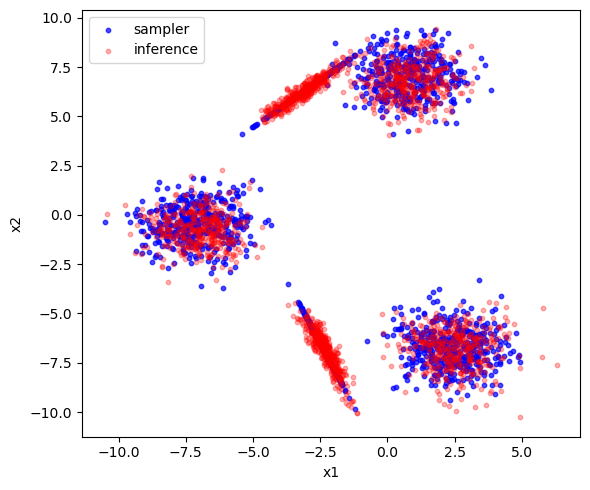

In [21]:
# Inference: K samples, c = int in {0,...,C-1} (one class) or C or None (uniform)
K = 2000
# use c = 0, ..., C-1 for conditional classes; 
# use c = C for unconditional.
# use None for uniform over all classes. (one view for all classes results)
c = None
x0_true, x0_gen = compare_inference(model, T=200, K=K, c=c, sampler=sampler, device=device, guidance=1)

# x0_true 是 (K, N) 的 tensor
x_true = x0_true.detach().cpu().numpy()

# x0_gen 是 (x, c) 的 tuple
x_gen_tensor, c_gen_tensor = x0_gen
x_gen = x_gen_tensor.detach().cpu().numpy()

# Stack: sampler (blue) + inference (red, transparent)
plt.figure(figsize=(6, 5))
plt.scatter(x_gen[:, 0], x_gen[:, 1], s=10, alpha=0.7, c='blue', label='sampler')
plt.scatter(x_true[:, 0], x_true[:, 1], s=10, alpha=0.3, c='red', label='inference')
plt.xlabel("x1")
plt.ylabel("x2")
plt.legend()
plt.tight_layout()
plt.show()

## Algebraically distill the score model and clean-prediction model

With the schedule $\alpha_t = 1-t, \sigma_t = t$, we can directly algebraically distill the score function and "clean prediction" from the pre-trained velocity field $v^*$, given by

$$ s^*(x_t, t, c) = \frac{t-1}{t} v^*(x_t, t, c) - \frac 1 t x_t ,$$
$$ x^*(x_t, t, c) = x_t - tv^*(x_t, t, c). $$

In [67]:
from score import CleanPredModel, ScoreModel

# Score and clean prediction (fixed pretrained v)
clean_model = CleanPredModel(model, guidance = 1)
score_model = ScoreModel(model)

A step path experiment.

Given a total $T$ steps, I first denoise Euler $T_v$ steps, then go one step backward to clean using ```clean_model```.

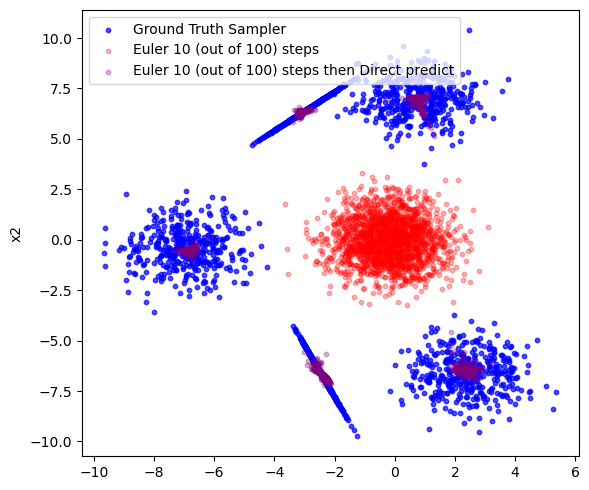

In [68]:
T = 100
T_v = 10
K = 2000
c = None

t_clean = 1 - T_v / T

xt_s = ode_backward(model, T=T, K=K, c=c, device=device, guidance=1, steps = T_v)
x0_s = clean_model(xt_s, t_clean, c)
x0, c = sampler(K, device=device, class_idx = c)

xt_s = xt_s.detach().cpu().numpy()
x0 = x0.detach().cpu().numpy()
x0_s = x0_s.detach().cpu().numpy()

plt.figure(figsize=(6, 5))
plt.scatter(x0[:, 0], x0[:, 1], s=10, alpha=0.7, c='blue', label='Ground Truth Sampler')
plt.scatter(xt_s[:, 0], xt_s[:, 1], s=10, alpha=0.3, c='red', label=f'Euler {T_v} (out of {T}) steps')
plt.scatter(x0_s[:, 0], x0_s[:, 1], s=10, alpha=0.3, c='purple', label=f'Euler {T_v} (out of {T}) steps then Direct predict')
plt.ylabel("x2")
plt.legend()
plt.tight_layout()
plt.show()


# 2. Distill the teacher model to a student model using distillation

**DMD distillation — step-by-step**

1. **Options**: PAIRING (alignment, augment) = (a=1, g=1); Mgen (generator steps per iteration); Mvel (velocity steps per iteration); Iter = 100.

2. **Phase 0 — One-step generator G_θ(z, c)**  
   Use the clean-prediction model x(z, 1, c) as a surrogate. Define a small MLP G_θ(z, c) and regress:
   ‖G_θ(z, c) − x(z, 1, c)‖² for e.g. 1000 steps (z ∼ N(0,I), c ∼ p(C)).

3. **Phase 1 (each iteration) — Train student velocity v_φ**  
   Freeze θ. If **PAIRING**: sample c ∼ p(C), z ∼ N(0,I), use coupling (z, G_θ(z,c)) via pair-style data to train v_φ(x_t, t, c) for Mvel steps. If **NOT PAIRING**: sample c, z, take x0 = G_θ(z,c) and ε ∼ N(0,I) independent; train v_φ for Mvel steps.

4. **Phase 2 (each iteration) — Distill score and update G_θ**  
   Freeze φ. Build s_φ from v_φ. Update θ for Mgen steps using the IKL gradient:
   E[(a(s_φ − s) + (1−g)(s − s_∅)) · (1−t) · ∂G_θ/∂θ] with x_t = G_θ(z,c), t ∼ U[0.01, 0.99].

5. **Loop**: Repeat Phase 1 and Phase 2 for Iter iterations (θ, φ, θ, φ, …).

### 2.1 Initiate a student model G_theta to match against the distilled clean_prediction model.

In [62]:
# DMD distillation: imports and options (run notebook from DMD directory)
from models.onestep import OneStepGenerator
from distillation import dmd_distillation

# Options: PAIRING (a=1, g=1); Mgen, Mvel, Iter
PAIRING = True
Mgen = 100
Mvel = 100
Iter = 100
reg_steps = 1000  # initial G regression to clean_prediction
batch_size = 128
a, g = 1.0, 1.0  # alignment and guidance
lr_G, lr_v = 1e-4, 1e-4
drop_label_prob = 0.0

In [69]:
# Phase 0: Warm-up distillation of G_theta from the wrapped teacher's clean-prediction model
from models.onestep import OneStepGenerator
from distillation import train_generator_regression


# Define a small one-step generator G_theta(z, c)
G_theta = OneStepGenerator(num_classes=C, dim=N, hidden_dim=64, num_layers=3, embed_dim=32).to(device)

# Regress G_theta(z, c) to the teacher clean prediction x(z, 1, c)
reg_steps = 2000
batch_size = 128
reg_losses = train_generator_regression(
    G=G_theta,
    clean_model=clean_model,
    num_steps=reg_steps,
    batch_size=batch_size,
    C=C,
    N=N,
    lr=1e-3,
    device=device,
    verbose=True,
)

  [G reg] step 100/2000 loss 0.010307
  [G reg] step 200/2000 loss 0.004180
  [G reg] step 300/2000 loss 0.006597
  [G reg] step 400/2000 loss 0.003631
  [G reg] step 500/2000 loss 0.002206
  [G reg] step 600/2000 loss 0.004226
  [G reg] step 700/2000 loss 0.003066
  [G reg] step 800/2000 loss 0.001870
  [G reg] step 900/2000 loss 0.001821
  [G reg] step 1000/2000 loss 0.001488
  [G reg] step 1100/2000 loss 0.001855
  [G reg] step 1200/2000 loss 0.004406
  [G reg] step 1300/2000 loss 0.002024
  [G reg] step 1400/2000 loss 0.004031
  [G reg] step 1500/2000 loss 0.001493
  [G reg] step 1600/2000 loss 0.001073
  [G reg] step 1700/2000 loss 0.005393
  [G reg] step 1800/2000 loss 0.002070
  [G reg] step 1900/2000 loss 0.001207
  [G reg] step 2000/2000 loss 0.001333


Plot the warmed-up student result against the actual one-step clean teacher predictor.

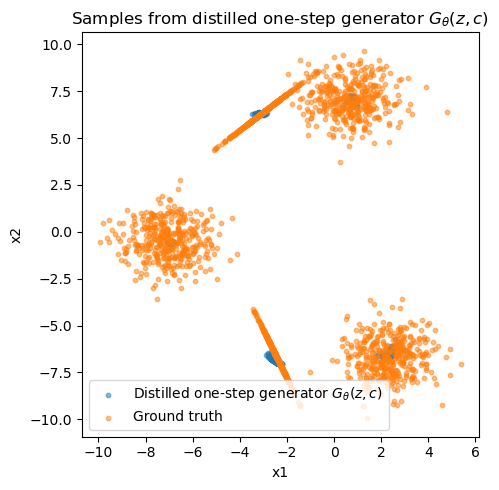

In [ ]:
K = 2000  
c = None

z = torch.randn(K, N, device=device)     
if c == None:
    c = torch.randint(0, C, (K,), device=device)  
else:
    c = torch.full((K,), c, device=device)

# 通过一步生成器得到样本
x_stud = G_theta(z, c).detach().cpu().numpy()
x_teac = clean_model(z, 1, c).detach().cpu().numpy()
x_true, c = sampler(K, device=device, class_idx = c)
x_true = x_true.detach().cpu().numpy()

plt.figure(figsize=(5, 5))
plt.scatter(x_stud[:, 0], x_stud[:, 1], s=10, alpha=0.5, label = 'Distilled one-step student generator $G_\\theta(z, c)$')
plt.scatter(x_teac[:, 0], x_teac[:, 1], s=10, alpha=0.5, label = 'Clean prediction $x(z, 1, c)$')
plt.scatter(x_true[:, 0], x_true[:, 1], s=10, alpha=0.5, label = 'Ground truth')
plt.xlabel("x1")
plt.ylabel("x2")
plt.title("Samples from distilled one-step generator $G_\\theta(z, c)$")
plt.legend()
plt.tight_layout()
plt.show()